## **CIFAR10 Artificial Neural Network Naive Classifier**

Our artificial neural network here would work great for classifying data into multiple (10) classes. 

Here we use Softmax. Given a specific example Softmax will output probabilities (probabilities of that example being each class) where all of them add up to 1. Note that here we are assuming that each example belongs to exactly one class and can't have multiple labels (e.g. Dog and Frog in this case wouldn't make sense but for classifying the genre of different Netflix movies you may have one movie that is Action, Sci-Fi, and comedy). We would also have to use a different function other than softmax and different approach.

Although our images are fairly complicated. This might have been fine for numerical data and classifying that or simple images e.g. black and white letters or something.

* Here this is going to require too much computation 
* It also is at risk of overfitting if there is too much variation and we can see that some of these cats for example, are in different positions and parts of the image and our network will struggle with this
* As we are feeding in data flattened (each image is just an array of numeric values 1x 3072 vector) it literally treats all of the parts of the image the same and data which is close together (in 2D maybe they are together) the same as far apart data 

Our images in 2D would be 32 x 32 x 3 size. 32 by 32 for dimensions height and width and the 3 for the colour depth (rgb, red green blue values like 120, -63, 24). 

Flattened each image is 1 x 3072. 

In the dataset folder "cifar-10-batches-py":
there are data batch 1 to 5 and a test batch

* data batch 1 to 5 are used for training and in total therefore there are 50000 images used for training
* test batch has 10000 image

Each batch has 10000 images so e.g. data batch 1 for training has 10000 images

As a flattened image is 1 x 3072 vector the whole data matrix for data batch 1 (used for training) is (10000, 3072)
We train this network on all 5 batches. Each batch it sees 10 times (thats why its 10 epochs and it starts at like low accuracy and works its way up). Then we test the network on the 1 testing batch using this unseen data to see if it can actually "see" and classify images correctly.

We get a low training accuracy and testing accuracy so we must change our approach.

## NN Convolutional Neural Network

This is better suited so we get higher accuracy on this complex image dataset than the flawed naive network.

In [1]:
# Using our working Data Download and Loading Modules
import File_Manager_Tar_Gz as fm

In [2]:
# For plotting and data pre-processing
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Machine Learning Module Used for Neural Network Classification
import tensorflow as tf

## Data Download and Loading

In [4]:
def download_and_extract_data():
    file_name = "cifar-10-python.tar.gz"
    website_link = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

    print(fm.download_file_tar_gz(dataset_link=website_link, dataset_file_name=file_name))
    print(fm.open_file_tar_gz(file_name))

In [5]:
download_and_extract_data()

Error: File already downloaded as file cifar-10-python.tar.gz/
False
Error: File already extracted as folder cifar-10-batches-py/
False


### Store all batches in a dictionary called 'data'

In [6]:
def load_data(file_names : list, folder_names : list):
    data_dico = {}
    for fil, fold in zip(file_names, folder_names):
        batch_file_path = "{}/{}".format(fold, fil)
        dico = fm.unpickle(batch_file_path)
        data_dico[dico[b'batch_label']] = dico

    return data_dico

In [7]:
file_names = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
data = load_data(file_names, ["cifar-10-batches-py"]*len(file_names))

In [8]:
# From cifar-10 https://www.cs.toronto.edu/~kriz/cifar.html our 10 classes
label_classes = ["airplane", "automobile", "bird", "cat",	"deer",	"dog", "frog", "horse", "ship", "truck"]

```python
data.keys()
>>> dict_keys([b'training batch 1 of 5', b'training batch 2 of 5', b'training batch 3 of 5', b'training batch 4 of 5', b'training batch 5 of 5', b'testing batch 1 of 1'])


data[b'training batch 1 of 5'] # >>>> png names.....

data[b'training batch 1 of 5'].keys() 
>>> dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

batch 1 training data and labels
print(data[b'training batch 1 of 5'][b'data'].shape)     # >>> (10000, 3072)     
print(len(data[b'training batch 1 of 5'][b'labels']))    # >>> 10000

data.keys() 
>>> dict_keys([b'training batch 1 of 5', b'training batch 2 of 5', b'training batch 3 of 5', b'training batch 4 of 5', b'training batch 5 of 5', b'testing batch 1 of 1'])

data[b'training batch 1 of 5'] # >>>> png names.....

data[b'training batch 1 of 5'].keys() 
>>> dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

batch 1 training data and labels
print(data[b'training batch 1 of 5'][b'data'].shape)     # >>> (10000, 3072)     
print(len(data[b'training batch 1 of 5'][b'labels']))    # >>> 10000


(10000, 3072)
10000 labels as it is batch 1 of 5 ie 10000 out of 50000 images
32 x 32 pixels image # 3 colour depth 32323 = 3072
```

## Explain Data Pre-processing

We may refer to data as data_dico to make it clear these are just example code so they are not accidently run without proper intention

```python
# Looking at the training batch 1 training examples

data_dico[b'training batch 1 of 5'][b'data'].shape # stored 10000 flattened images in 1d arrays each of size 3072
>>> (10000, 3072)

data_dico[b'training batch 1 of 5'][b'data'][0] # The 1st image which is stored as a row of (3072,)
>>> array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)
```

According to [cifar-10 dataset website](https://www.cs.toronto.edu/~kriz/cifar.html), it confirms that yes this is a 10000 by 3072 2D numpy array and that each of these rows (which are numpy arrays 1 x 3072 aka (3072,)) represent a 32 by 32 coloured image.

Each image is stored as RGB values. It also tells us that the first 1024 values in this row represent the red colour values. The next 1024 values are green with the last 1024 being blue. So in total that is 3072 data values for each image.

So if we wanted to visualise an image from this array 3072 of data points in 2 dimensions so it is a 32 by 32 image by 3 for 3 colour depth, then we should note that the image is in 'row-major order' so the first 32 values of the array would be red colour values for the first row of the image.

Therefore we must reshape this data to 32 by 32 by 3 (32 rows, 32 columns, 3 colour depth) format so we can plot it in matplotlib for visualisation.

So first due to the 'row-major' order as well we must do 2 operations;
* The first will reshape each 3072 array (from our 10000 by 3072 matrix), into a 3 by 32 by 32 3D numpy array
    * with the 1st dimension representing the 3 RGB channels
    * with the 2nd dimension representing the 32 pixels in a row
    * and finally the 3rd dimension representing the 32 columns

* The second operation will just transpose our matrix so we can put that 1st RGB dimension at the back, so we turn the shape from (3,32,32) to a (32,32,3)
    * we do this by passing in parameters into the transpose function which labels the columns [RGB, pixel rows,  pixel columns] as [1,2,0] and re-orders       them as [0,1,2] so [pixel rows,  pixel columns, RGB]. Therefore we can put that 1st RGB dimension at the back. This means each RGB value for each pixel (of each image) will be stored together as shown below

### Reshape and Transpose
Example on just 1 image:
```python

an_image = data_dico[b'training batch 1 of 5'][b'data'][0].reshape([3,32,32]).transpose([1,2,0])
print(an_image[0][0].shape)
>>> (3,)
print(an_image[0][0]) # a pixel 3 with r g b values 
>>> [59, 62, 63]

# Reshape (3,32,32) as 
# 3 is for r g b values
# 32 is for row of pixels
# other 32 is for column of pixels

# Transpose to (32,32,3) to store RBG values together for each pixel for each image
# 32 is for row of pixels
# other 32 is for column of pixels
# 3 is for r g b values

We convert from row-major or column-major order
```
#### We can execute this reshape and transpose on the whole dataset in this next normalise function but we will just see how it effects images individually when we plot them below.

### Plotting

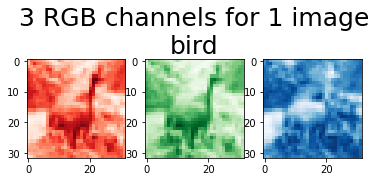

In [9]:
def image_RGB_channels_viewer(data_dico, batch_name, index):
    if data[batch_name][b'data'][index].ndim == 1: # check if 1 flattened vector for image
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(data_dico[batch_name][b'data'][index].reshape([3,32,32])[0], cmap='Reds_r')
        ax[1].imshow(data_dico[batch_name][b'data'][index].reshape([3,32,32])[1], cmap='Greens_r')
        ax[2].imshow(data_dico[batch_name][b'data'][index].reshape([3,32,32])[2], cmap='Blues_r')

        ax[1].set_title("3 RGB channels for 1 image\n"+label_classes[data_dico[batch_name][b'labels'][index]], size=25)
        plt.show()
    else:
        print("ERROR: Data provided is not 1 flattened vector for image. Please use plot_image_data instead. Data dimension currently is: {}".format(
                data[batch_name][b'data'][index].ndim))

# Plot 3 RGB channels for training image in batch 1 separately 
image_RGB_channels_viewer(data, b'training batch 1 of 5', 6)

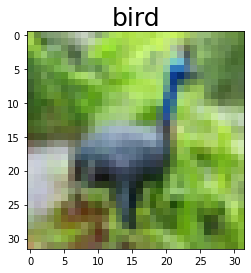

In [10]:
def plot_image_data(the_image_data, label):
    fig, ax = plt.subplots()
    ax.imshow(the_image_data)
    ax.set_title(label, size=25)
    return fig, ax

def image_viewer_from_flattened_data(dico, batch_name, index):
    if data[batch_name][b'data'][index].ndim == 1: # check if 1 flattened vector for image
        a_fig, a_ax = plot_image_data(the_image_data=data[batch_name][b'data'][index].reshape([3,32,32]).transpose([1,2,0]),
                            label=label_classes[data[batch_name][b'labels'][index]])
        plt.show()
    else:
        print("ERROR: Data provided is not 1 flattened vector for image. Please use plot_image_data instead. Data dimension currently is: {}".format(
                data[batch_name][b'data'][index].ndim))

# training image in batch 1
# 3D Numpy array Real image. Default settings from imshow.
image_viewer_from_flattened_data(dico=data, batch_name=b'training batch 1 of 5', index=6)

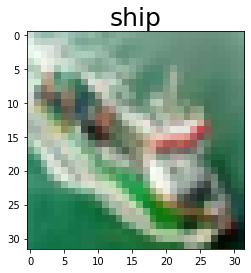

In [11]:
# Testing image in testing batch
image_viewer_from_flattened_data(dico=data, batch_name=b'testing batch 1 of 1', index=15)

## Execute Data Pre-processing: Normalisation and Reshape Function

### Quick Check before Normalisation

```Python
print("Training set min: {}, max: {}".format(b1_dico[b'data'].min(), b1_dico[b'data'].max())) # Training set min: 0, max: 255
print("Labels min: {}, max: {}".format(min(b1_dico[b'labels']), max(b1_dico[b'labels']))) # Labels min: 0, max: 9
```
Data values will be between 0 and 255 and we will check this during the normalising process for each batch

We see that a singular image can be changed using: 
```python
data_dico[b'training batch 1 of 5'][b'data'][index].reshape([3,32,32]).transpose([1,2,0])
```
For a whole batch of images we can do this: 
```python
data_dico[b'training batch 1 of 5'][b'data'].shape
# >>> (10000, 3072)
data_dico[b'training batch 1 of 5'][b'data'].reshape(10000, 3, 32, 32).transpose([0,2,3,1]).shape  # convert from 2D numpy array (10000,3072) to 4D numpy array (10000, 32, 32, 3)
# >>> (10000, 32, 32, 3)
```

In [12]:
def normalise_data(data_dico):
    """ For each batch data in data dico, normalise this data between 0 and 1 and convert reshape data matrices for proper image representation.

    E.g. Convert a batch from convert from 2D numpy array (10000,3072) to 4D numpy array (10000, 32, 32, 3)
    where 10000 is number of training/testing examples, 32 pixel row, 32 pixel column, 3 colour depth.
    As a result, each image/example in the 4D numpy array of a batch, is now represented as a 3D numpy array (32, 32, 3) rather than rather than a 1D numpy array of size (3072,).
    
    :param data_dico: dictionary of format described above.
    :return: Changes data dictionary passed and returns
    """

    for key in data_dico.keys(): # A key represent a name of batch. Includes training batch 1 to 5 and testing batch.
    
        # Normalise data from 0 and 255 to between 0 and 1    
        data_dico[key][b'data'] = data_dico[key][b'data'] / data_dico[key][b'data'].max()

        # Convert a batch from convert from 2D numpy array (10000,3072) to 4D numpy array (10000, 32, 32, 3) although 10000 can be any number of examples:
        n = data_dico[key][b'data'].shape[0] # number of training/testing examples
        data_dico[key][b'data'] = data_dico[key][b'data'].reshape(n,3,32,32).transpose([0,2,3,1])

    return data_dico

In [13]:
data = normalise_data(data)

### Final Check to see if normalisation and reshaping done correctly by plotting 

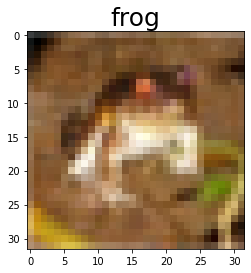

(32, 32, 3)

In [14]:
def image_viewer_from_4D_data(dico, batch_name, index):
    plot_image_data(dico[batch_name][b'data'][index], label_classes[dico[batch_name][b'labels'][index]])
    plt.show()

image_viewer_from_4D_data(data, b'training batch 1 of 5', 0)
data[b'training batch 1 of 5'][b'data'][0].shape

In [15]:
data[b'training batch 1 of 5'][b'data'].shape

(10000, 32, 32, 3)

## Neural Network Classification
TensorFlow Machine Learning Module Used for Neural Network Classification

In [16]:
# We use softmax for classification at the end for the 10 classes to get relative probabilities so if you add them all up you get 1
# Highest probability will be what the network has predicted is the label for that image

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32,32,3)), # Here we flatten each image back to 1D again just for experimentation with this Naive network
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(len(label_classes), activation=tf.nn.softmax) # len(label_classes) is 10
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# We are going to use sparse_categorical_crossentropy
# After some testing I realise that categorical_crossentropy is used for labels being one hot encoded values for example [[0,1], [1,0]] like this 
# whereas sparse_categorical_crossentropy is for if your labels being direct values e.g. [2, 1] and this would be more efficient
# in terms of space and times complexity as we don't need to store another list/vector for each label, we store a singular value
#  and also it takes less time as we directly access the label from a single 1d list rather than searching through a list inside of another list to find where the 1 is that signifies the 1 hot encoded label class

In [18]:
'''
for k in data.keys():
    if k != b'testing batch 1 of 1':
        # k is batch name
        x = data[k][b'data']
        y = np.array(data[k][b'labels'])

        model.fit(x, y, epochs=10) # had to but labels into a numpy array rather than a list
'''

i = 0
k = list(data.keys())[i]
x = data[k][b'data']
y = np.array(data[k][b'labels'])
model.fit(x, y, epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 230us/sample - loss: 2.0442 - accuracy: 0.2663
Epoch 2/10
10000/10000 [==============================] - 1s 150us/sample - loss: 1.8833 - accuracy: 0.3203
Epoch 3/10
10000/10000 [==============================] - 1s 138us/sample - loss: 1.8254 - accuracy: 0.3426
Epoch 4/10
10000/10000 [==============================] - 1s 142us/sample - loss: 1.7672 - accuracy: 0.3712
Epoch 5/10
10000/10000 [==============================] - 1s 147us/sample - loss: 1.7337 - accuracy: 0.3760
Epoch 6/10
10000/10000 [==============================] - 2s 152us/sample - loss: 1.6915 - accuracy: 0.3966
Epoch 7/10
10000/10000 [==============================] - 1s 139us/sample - loss: 1.6738 - accuracy: 0.4026
Epoch 8/10
10000/10000 [==============================] - 1s 146us/sample - loss: 1.6435 - accuracy: 0.4130
Epoch 9/10
10000/10000 [==============================] - 2s 161us/sample - loss: 1.6295 - accuracy: 0.4171
Epoch

In [19]:
i = 1
k = list(data.keys())[i]
x = data[k][b'data']
y = np.array(data[k][b'labels'])
model.fit(x, y, epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 160us/sample - loss: 1.7378 - accuracy: 0.3860
Epoch 2/10
10000/10000 [==============================] - 2s 153us/sample - loss: 1.7008 - accuracy: 0.3986
Epoch 3/10
10000/10000 [==============================] - 2s 150us/sample - loss: 1.6756 - accuracy: 0.4096
Epoch 4/10
10000/10000 [==============================] - 2s 153us/sample - loss: 1.6469 - accuracy: 0.4187
Epoch 5/10
10000/10000 [==============================] - 2s 152us/sample - loss: 1.6270 - accuracy: 0.4264
Epoch 6/10
10000/10000 [==============================] - 1s 150us/sample - loss: 1.6186 - accuracy: 0.4294
Epoch 7/10
10000/10000 [==============================] - 2s 153us/sample - loss: 1.6185 - accuracy: 0.4248
Epoch 8/10
10000/10000 [==============================] - 2s 156us/sample - loss: 1.5813 - accuracy: 0.4384
Epoch 9/10
10000/10000 [==============================] - 2s 154us/sample - loss: 1.5842 - accuracy: 0.4418
Epoch

In [20]:
i = 2
k = list(data.keys())[i]
x = data[k][b'data']
y = np.array(data[k][b'labels'])
model.fit(x, y, epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 148us/sample - loss: 1.6400 - accuracy: 0.4175
Epoch 2/10
10000/10000 [==============================] - 2s 154us/sample - loss: 1.6103 - accuracy: 0.4250
Epoch 3/10
10000/10000 [==============================] - 2s 158us/sample - loss: 1.5941 - accuracy: 0.4295
Epoch 4/10
10000/10000 [==============================] - 2s 159us/sample - loss: 1.5724 - accuracy: 0.4366
Epoch 5/10
10000/10000 [==============================] - 2s 164us/sample - loss: 1.5512 - accuracy: 0.4474
Epoch 6/10
10000/10000 [==============================] - 2s 161us/sample - loss: 1.5423 - accuracy: 0.4402
Epoch 7/10
10000/10000 [==============================] - 2s 167us/sample - loss: 1.5324 - accuracy: 0.4450
Epoch 8/10
10000/10000 [==============================] - 2s 169us/sample - loss: 1.5102 - accuracy: 0.4551
Epoch 9/10
10000/10000 [==============================] - 2s 166us/sample - loss: 1.4973 - accuracy: 0.4578
Epoch

In [21]:
i = 3
k = list(data.keys())[i]
x = data[k][b'data']
y = np.array(data[k][b'labels'])
model.fit(x, y, epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 164us/sample - loss: 1.6428 - accuracy: 0.4187
Epoch 2/10
10000/10000 [==============================] - 2s 169us/sample - loss: 1.6031 - accuracy: 0.4277
Epoch 3/10
10000/10000 [==============================] - 2s 163us/sample - loss: 1.6037 - accuracy: 0.4297
Epoch 4/10
10000/10000 [==============================] - 2s 171us/sample - loss: 1.5783 - accuracy: 0.4434
Epoch 5/10
10000/10000 [==============================] - 2s 187us/sample - loss: 1.5624 - accuracy: 0.4474
Epoch 6/10
10000/10000 [==============================] - 2s 174us/sample - loss: 1.5624 - accuracy: 0.4482
Epoch 7/10
10000/10000 [==============================] - 2s 176us/sample - loss: 1.5423 - accuracy: 0.4481
Epoch 8/10
10000/10000 [==============================] - 2s 182us/sample - loss: 1.5365 - accuracy: 0.4524
Epoch 9/10
10000/10000 [==============================] - 2s 186us/sample - loss: 1.5139 - accuracy: 0.4576
Epoch

In [22]:
i = 4
k = list(data.keys())[i]
x = data[k][b'data']
y = np.array(data[k][b'labels'])
model.fit(x, y, epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 215us/sample - loss: 1.6292 - accuracy: 0.4209
Epoch 2/10
10000/10000 [==============================] - 2s 237us/sample - loss: 1.5843 - accuracy: 0.4355
Epoch 3/10
10000/10000 [==============================] - 3s 267us/sample - loss: 1.5690 - accuracy: 0.4456
Epoch 4/10
10000/10000 [==============================] - 2s 213us/sample - loss: 1.5462 - accuracy: 0.4467
Epoch 5/10
10000/10000 [==============================] - 3s 259us/sample - loss: 1.5420 - accuracy: 0.4553
Epoch 6/10
10000/10000 [==============================] - 2s 250us/sample - loss: 1.5263 - accuracy: 0.4573
Epoch 7/10
10000/10000 [==============================] - 2s 207us/sample - loss: 1.5196 - accuracy: 0.4578
Epoch 8/10
10000/10000 [==============================] - 3s 272us/sample - loss: 1.5059 - accuracy: 0.4577
Epoch 9/10
10000/10000 [==============================] - 2s 249us/sample - loss: 1.4939 - accuracy: 0.4687
Epoch

In [23]:
i = 5
k = list(data.keys())[i]
x = data[k][b'data']
y = np.array(data[k][b'labels'])

# testing on unseen data
validation_loss, validation_accuracy = model.evaluate(x, y)

10000/10000 [==============================] - 2s 233us/sample - loss: 1.5662 - accuracy: 0.4460


In [24]:
print("Testing Accuracy on our unseen data: {}".format(validation_accuracy))

Testing Accuracy on our unseen data: 0.44600000977516174
